# Probabilistic Programming

_David Tolpin, david.tolpin@gmail.com_

Probabilistic programming embraces **generative Bayesian approach** to data science. This tutorial introduces the concepts of 
* generative machine learning,
* Bayesian statistical modeling,
* Bayesian flow of statistical analysis.

There are many probabilistic programming environments in most major languages. We will use [NumPyro](https://num.pyro.ai/). NumPyro  is based on [Python](https://www.python.org) and is backed by [JAX](https://jax.readthedocs.io/en/latest/notebooks/quickstart.html), a powerful library for numerical computing and [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation).


## Generative Machine Learning

### What Does Machine Learning Do?

Machine _learning_ should be machine _training_ instead:

* takes a bunch of code --- a **model**,
* feeds old data to the model --- **training**,
* passes new data through the model --- **inference**.

Example: [MNIST](https://en.wikipedia.org/wiki/MNIST__database).

### Discriminative vs. Generative

* Discriminative ML:

> Model(question, parameters) $\rightarrow$ answer

Runs the model _forward_ for inference.

* Generative ML:

> Model(answer, parameters) $\rightarrow$ question

Runs the model _backward_ for inference.

In both approaches, the parameters are adjusted until the answers are good enough for the questions. 

### Running Backward

Running a model (or a program) backward is impossible, in general, but can be approximated. Approximation methods depend on the model kind and structure. For example,

* Message passing for Bayesian networks.
* Markov Chain Monte Carlo for complex but low dimensional models.
* Variational inference for high-dimensional models and big data.
* ... and many other approaches.

Inference algorithms for generative machine learning is an [active area of research](https://scholar.google.com/scholar?hl=en&as_sdt=0%2C5&q=approximate+bayesian+inference&btnG=).

### Probabilistic Programming

Probabilistic programming is an approach to statistical machine learning, in which

* models are programs, 
* inference is execution of the programs.

Representing statistical models as programs in a language such as Python or Julia lets introduce complex concepts into the models and combine structured human knowledge ('science') and raw observations ('data').

You need probabilistic programming when you 

* have **small data**,
* exploit **laws** of nature or society,
* look for **novelties**.

### Bayesian Data Analysis

Bayesian data analysis is an applied discipline of analysis, modelling, and forecasting. Modern BDA uses probabilistic programming as a core tool. BDA involves

1. Designing the generative model (_data story_).
2. Conditioning the model on observed data (_update_).
3. Evaluating the fit of the model to the data (_critique_).

Example: [Bayesian regression with NumPyro](https://num.pyro.ai/en/stable/tutorials/bayesian_regression.html).

## Bayesian Workflow

Let us now apply the Bayesian data analysis to a simple problem. We will follow the process known as [Bayesian workflow](https://arxiv.org/abs/2011.01808):

1. Formulate the problem.
2. Design and implement a generative model (as a probabilistic program in NumPyro).
3. Numerically analyze the prior distribution specified by the generative model.
4. Fit the model to the data --- perform the inference.
5. Check the inference results for convergence.
6. Numerically analyze the fit of the posterior distribution to the data.

In [1]:
import numpy
import scipy
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import jax
import time

### Problem: Estimating success probability of a robot

Robot Alice can perform one action $A=\{a\}$ and can pass between three states $S=\{s_{start}, s_{success}, s_{failure}\}$. When the action is performed in state $s_{start}$, the robot passes to either $s_{success}$ or $s_{failure}$, in other states, the action has no effect.  We believe that there is a fixed probability $p$ with which the robot passes from $s_{start}$ to $_{success}$. In order to operate the robot, we want to estimate $p$.

We operated the robot several times in state $s_{start}$, letting him to perform $a$, and got the following _sequence_ of outcomes: $[s_{success}, s_{failure}, s_{success}, s_{success}, s_{failure}, s_{success}, s_{success}, s_{success}, s_{failure}, s_{failure}]$. What can we say about $p$?

Let's formalize. We have a vector $\pmb{o}$ of observations (1 - success, 0 - failure)

In [2]:
OBSERVATIONS = [1, 0, 1, 1, 0, 1, 1, 1, 0, 0]

and a latent variable $p$  which affects the observations we get. We assume that observations are random, and we might have gotten a different sequence of successes and failures if we repeated the experiment. 

Looking at this the other way around, even if we new the 'true' $p$, we might get the _same_ observations for _different_ 'true' values of $p$, by chance. This means that we cannot be absolutely certain about the value of $p$ given a finite set of observations.

So, the question is: _What is our belief about $p$ given the observations?_

### Generative model

To answer a question about data, we need a model. Our approach is to specify a _generative model_, that is, a model that tells the story of the robot taking an action in the state. We will run _inference_ on the model to get an approximation of the _parameter posterior_, which is, in our case, our belief about the values of $p$.

The generative model for our robot experiment is

\begin{aligned}
p & \sim \mathrm{Beta}(1, 1) \\
o & \sim \mathrm{Bernoulli}(p),\,\mbox{for each}\,o \in \pmb{o}
\end{aligned}

The first line specifies the _prior belief_ about $p$. $\mathrm{Beta}(1, 1)$ is a fancy way to say that $p$ is uniformly distributed between 0 and 1:

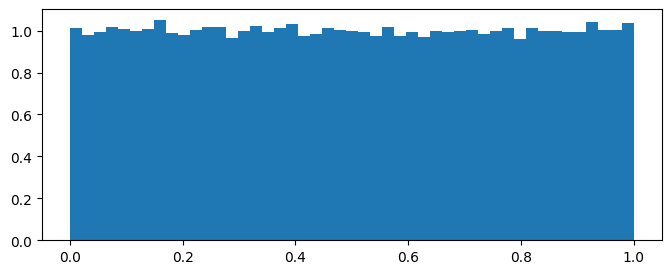

In [3]:
plt.figure(figsize=(8, 3))
plt.hist(scipy.stats.beta(1, 1).rvs(100000), bins="auto", density=True)
_=_

However, we could have chosen a more complex prior, provided we have a reason to. For example, we may believe that $p$ is likely to be around $0.6$ ($\mathrm{Beta}(3, 2)$):

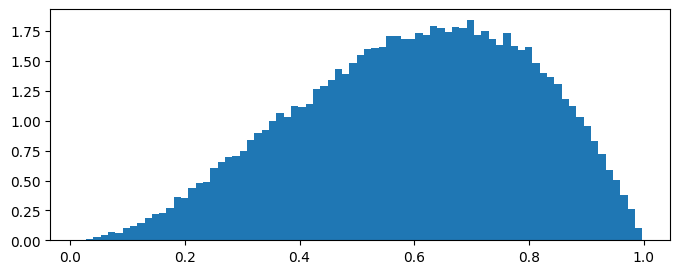

In [4]:
plt.figure(figsize=(8, 3))
plt.hist(scipy.stats.beta(3, 2).rvs(100000), bins="auto", density=True)
_=_

or even that most robots are dumb, but some are very smart:

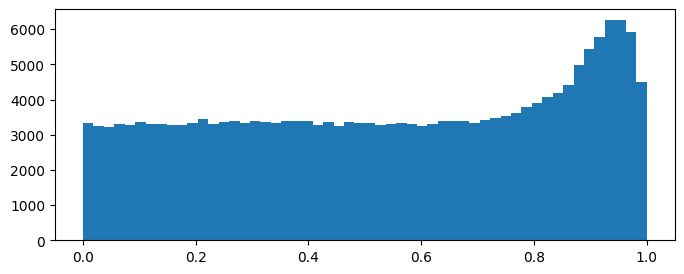

In [5]:
plt.figure(figsize=(8, 3))
plt.hist(numpy.concatenate([
        # a mixture of 0.9 Beta(1, 1) and 0.1 Beta(20, 2)
        scipy.stats.beta(1, 1).rvs(180000), 
        scipy.stats.beta(20, 2).rvs(20000)]), 
    bins="auto")
_=_

The second line above specifies the _conditional distribution_ of observations given $p$, in our case we state that observations are independent, and Bernoulli-distributed. Bernoulli-distributed variables can be either 0 or 1, and the portion of 1s is specified by $p$:

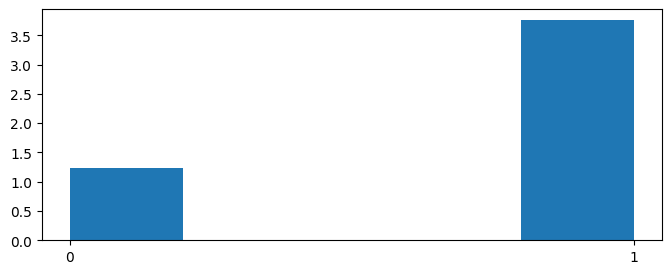

In [6]:
plt.figure(figsize=(8, 3))
plt.hist(scipy.stats.bernoulli(0.75).rvs(100000), bins=5, align='mid', density=True)
plt.xticks([0, 1], [0, 1])
_=_

#### Generative model

First thing NumPyro provides is a [DSL](https://en.wikipedia.org/wiki/Domain-specific_language) for specifying generative models in Python.

```python
def robot(obs):
    # p ~ Beta(1, 1)
    p = numpyro.sample("p", dist.Beta(1, 1))
    with numpyro.plate("obs", len(obs)):
        # o ~ Bernoulli(p)
        numpyro.sample("o", dist.Bernoulli(p), obs=obs)
```

The model above is a complete NumPyro model, suitable for inference. Behind the scenes, it computes the joint log probability, but it looks just like the statistical generative model.

We could use the model as implemented, but to be able to do a bit more _automatically_, we want to be able to call the model without observations — to simulate model's predictions before any data is seen (this is called _predictive prior_).

In [7]:
def robot(obs=None, nobs=len(OBSERVATIONS)):
    """Robot model with NumPyro.
    """
    if obs is not None:  # for prior predictive
        nobs = len(obs)
    # p ~ Beta(1, 1)
    p = numpyro.sample("p", dist.Beta(1, 1))
    with numpyro.plate("obs", nobs):
        # o ~ Bernoulli(p)
        numpyro.sample("o", dist.Bernoulli(p), obs=obs)

#### Prior predictive

The first step we want to perform with any model is to examine its prior predictive, that is, the kind of observations this model is in general able to 'imagine'. NumPyro provides class `Predictive` for this purpose.

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


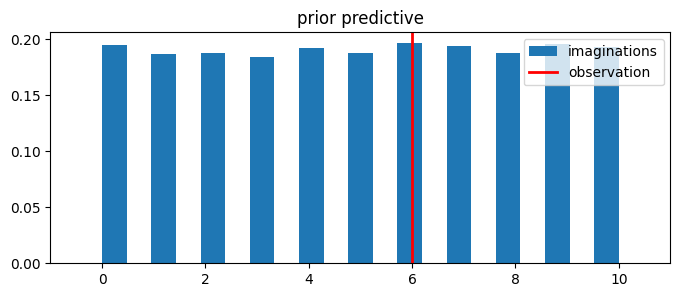

In [8]:
prior_predictive = numpyro.infer.Predictive(robot, num_samples=10000)
prior_samples = prior_predictive(jax.random.PRNGKey(int(time.time() * 1E6)))

plt.figure(figsize=(8, 3))
plt.xlim(-1, len(OBSERVATIONS)+1)
plt.hist([sum(o) for o in prior_samples['o']], density=True, bins=len(OBSERVATIONS)*2+1, label="imaginations")
plt.axvline(sum(OBSERVATIONS), color="red", lw=2, label="observation")
plt.title("prior predictive")
plt.legend()
_=_

The above plot of prior predictive helps us analyse our model even before we performed any inference. The actual observation (number of successes out number of trials) is _well covered by the prior_. This means that, given this observation, the model will be able to infer the posterior reasonably efficiently. If, for example, the prior mass on the actual observation were very small, such as if the prior were $\mathrm{Beta(1, 10)}$, our model would be _misspecified_, and the inference would not work well.

#### Inference

NumPyro supplies efficient MCMC inference algorithms. A default choice is called [NUTS](https://arxiv.org/abs/1111.4246).  NumPyro's NUTS is both much faster and much better converging inference algorithm than the naive version of MCMC we wrote earlier.

In [9]:
nuts_kernel = numpyro.infer.NUTS(robot)
mcmc = numpyro.infer.MCMC(
    nuts_kernel,
    num_warmup=500,
    num_chains=4,
    num_samples=5000)

mcmc.run(jax.random.PRNGKey(int(time.time() * 1E6)), obs=jax.numpy.array(OBSERVATIONS))

/tmp/ipykernel_44948/396090589.py:2: UserWarning: There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(4)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(
sample: 100%|█| 5500/5500 [00:01<00:00, 3997.24it/s, 1 steps of size 1.31e+00. acc. prob=0.9
sample: 100%|█| 5500/5500 [00:00<00:00, 10506.59it/s, 3 steps of size 1.04e+00. acc. prob=0.
sample: 100%|█| 5500/5500 [00:00<00:00, 10620.71it/s, 3 steps of size 1.21e+00. acc. prob=0.
sample: 100%|█| 5500/5500 [00:00<00:00, 10654.71it/s, 3 steps of size 1.09e+00. acc. prob=0.


When the algorithm finished running, the first thing we want to check is whether the inference results are informative. For this purpose, we 

1. Run several (4) Monte Carlo chains.
2. Print and review summary statistics of the samples in the chains.

In [10]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         p      0.58      0.14      0.59      0.35      0.80   7872.58      1.00

Number of divergences: 0


The two important numbers here are the number of effective samples `n_eff` ($N_{eff}$) and the metric called `r_hat` ($\hat R$). 
1. $N_{eff}$ estimates how many 'independent'  samples we got in the posterior. The way MCMC works, we may get 10000 samples which are all have the same or very close values, and do not approximate the posterior well. 
2. [$\hat R$](https://mc-stan.org/rstan/reference/Rhat.html) compares correlation with the same chain and among different chains. MCMC is a random algorithm, and different Markov chains may behave differently. We want the model to be good enough, and to run it for long enough, so that different chains 'forget' about their starting points and converge to the same random behavior. if $\hat R$ is close to 1, then we are fine. If $\hat R$ is greater than 1.1, we should discard the posterior and look for ways to improve the converged, either through a longer warmup, or by modifying the model.

Our model is small and simple, so the inference has come out well, but you are welcome to ‘break’ the model or the inference to get pathological values of $N_{eff}$ or $\hat R$, just for fun and education.

#### Posterior

The first thing we want to show is, just in our DIY solution, the posterior distribution of $p$.

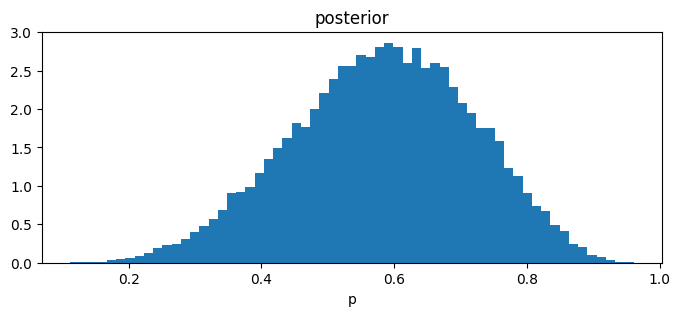

In [11]:
plt.figure(figsize=(8, 3))
plt.title("posterior")
plt.xlabel("p")
plt.hist(mcmc.get_samples()['p'], density=True, bins="auto")
_=__=_

_How do we check that the posterior is right?_

For this simple model, we can compute the posterior analytically. The inferred posterior approximates quite well the true posterior, which is quite expected.

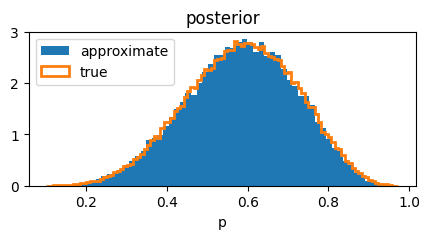

In [12]:
plt.figure(figsize=(5, 2))
plt.title("posterior")
plt.xlabel("p")
plt.hist(mcmc.get_samples()['p'], density=True, bins="auto", label="approximate")
Dp = scipy.stats.beta(7, 5) 
plt.hist(Dp.rvs(100000), histtype="step", lw=2, bins="auto", density=True, label="true")
plt.legend()
_=__=_

#### Posterior predictive

In reality though, we won't be able to check the approximate posterior by comparing to the true one (we do not know the true one). So, we should find another way to check that the model converged to something reasonable. We can do this using _posterior predictive_.

We generate the posterior predictive using the same tool as we used for prior predictive, only instead of sampling $p$ from the prior we use the posterior samples of $p$. Technically, this is achieved by passing `posterior_samples` to `Predictive`.

In [13]:
posterior_predictive = numpyro.infer.Predictive(robot, posterior_samples=mcmc.get_samples())
posterior_samples = posterior_predictive(jax.random.PRNGKey(int(time.time() * 1E6)))

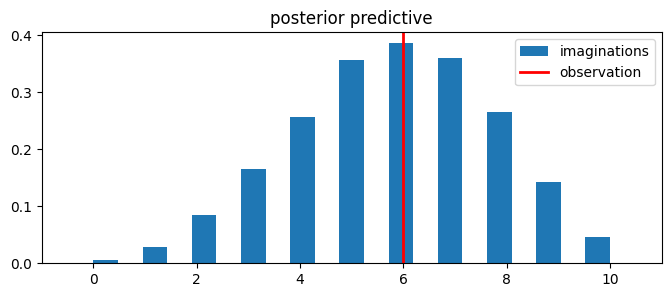

In [14]:
plt.figure(figsize=(8, 3))
plt.xlim(-1, len(OBSERVATIONS)+1)
plt.hist([sum(o) for o in posterior_samples['o']], density=True, bins=len(OBSERVATIONS)*2+1, label="imaginations")
plt.axvline(sum(OBSERVATIONS), color="red", lw=2, label="observation")
plt.title("posterior predictive")
plt.legend()
_=_

The above plot looks fine: the imaginations are concentrated around the observation, with  the maximum mass near the observation. We can formalize this by computing the ‘p-value’ of the observation given the predictive posterior, that is, the probability that an imagined observation is greater (or smaller) than the actual one:

In [15]:
p_value = sum(posterior_samples['o'].sum(axis=1) >= sum(OBSERVATIONS))/len(posterior_samples['o'])
print(f"p_value = {p_value:.3f}")

p_value = 0.572


Depending on how strong the prior and how much data we have, `p_value` between 0.3 and 0.7 is an indication that our posterior is fine. Extreme values, like 0.1 or 0.9 or more extreme, point at a problem in the model.

### Further steps

We didn't have the capacity to cover

* summarizing the posterior,
* model extension,
* model evluation and comparison.

This topics are covered in the [second part](https://www.youtube.com/watch?v=uAZq3QhUgSw&t=2347s) of a tutorial on Bayesian workflow I gave earlier.